# Query Wikidata for GeoCorpora locations
In which we attempt to find [Wikidata](https://www.wikidata.org/) and [DBPedia](dbpedia.org/ontology/Place) entries for the GeoCorpora candidates.

In [114]:
import pandas as pd
from SPARQLWrapper import SPARQLWrapper, JSON
from time import sleep
from ast import literal_eval
import json
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

## Load data

In [77]:
REPLACE_PAIRS = [
    (" u'", '"'),
    ("{u", "{"),
    ("[u", "["),
    ("':", '":'),
    ("',", '",'),
    ("{'", '{"'),
    ("'}", '"}'),
    ("['", '["'),
    ("']", '"]'),
    ("\\", '')
]
def clean_dict_str(x):
    for old, new in REPLACE_PAIRS :
        x = x.replace(old, new)
    return(x)
def decode_dict(x):
    # cleanup first
    x_clean = clean_dict_str(str(x))
    try:
        x_dict = json.loads(x_clean)
    except Exception, e:
        x_dict = {}
    return(x_dict)
geocorpora_query_results = pd.read_csv('../../data/mined_tweets/GeoCorpora/geocorpora_opencage_query_results.tsv', sep='\t', index_col=False)
# also extract dicts
dict_vars = ['annotations', 'bounds', 'components']
for v in dict_vars:
    geocorpora_query_results.loc[:, v] = geocorpora_query_results.loc[:, v].apply(decode_dict)

In [78]:
geocorpora_query_results.head()

,annotations,bounds,components,confidence,formatted,geometry,query
0,"{u'MGRS': u'32NKL6270635529', u'sun': {u'rise'...","{u'northeast': {u'lat': 5.7300358, u'lng': 7.5...","{u'country': u'Nigeria', u'ISO_3166-1_alpha-2'...",1,"Rivers, Nigeria","{u'lat': 4.8416028, u'lng': 6.8604088}",rivers
1,"{u'MGRS': u'14UMA1160342817', u'sun': {u'rise'...","{u'northeast': {u'lat': 50.0415453, u'lng': -1...","{u'city': u'Rivers', u'ISO_3166-1_alpha-2': u'...",7,"Rivers, MB R0K 1X0, Canada","{u'lat': 50.0310937, u'lng': -100.2342492}",rivers
2,"{u'MGRS': u'29UNU3128635886', u'ITM': {u'easti...","{u'northeast': {u'lat': 52.6821393, u'lng': -8...",{u'city': u'Metropolitan District of Limerick'...,8,"Rivers, Metropolitan District of Limerick, Cou...","{u'lat': 52.6720155, u'lng': -8.5373025}",rivers
3,"{u'MGRS': u'29UNU3374436846', u'ITM': {u'easti...","{u'northeast': {u'lat': 52.690501, u'lng': -8....",{u'city': u'Metropolitan District of Limerick'...,8,"Ballyvarra, Metropolitan District of Limerick,...","{u'lat': 52.680501, u'lng': -8.5008587}",rivers
4,"{u'MGRS': u'30UVA1348184239', u'currency': {u'...","{u'northeast': {u'lat': 50.4039014, u'lng': -4...","{u'road': u'The Rivers', u'ISO_3166-1_alpha-2'...",9,"The Rivers, Wearde Quay PL12 4PD, United Kingdom","{u'lat': 50.4038213, u'lng': -4.2174708}",rivers


In [22]:
print(geocorpora_query_results.loc[:, 'components'][0])
print(geocorpora_query_results.loc[:, 'annotations'][0])

{u'country': u'Nigeria', u'ISO_3166-1_alpha-2': u'NG', u'_type': u'state', u'country_code': u'ng', u'state': u'Rivers'}
{u'MGRS': u'32NKL6270635529', u'callingcode': 234, u'sun': {u'rise': {u'civil': 1515302460, u'astronomical': 1515299340, u'apparent': 1515303780, u'nautical': 1515300900}, u'set': {u'civil': 1515347820, u'astronomical': 1515350940, u'apparent': 1515346500, u'nautical': 1515349380}}, u'Maidenhead': u'JJ34ku31fx', u'currency': {u'html_entity': u'&#x20A6;', u'name': u'Nigerian Naira', u'alternate_symbols': [], u'subunit_to_unit': 100, u'symbol_first': 1, u'thousands_separator': u',', u'decimal_mark': u'.', u'iso_numeric': 566, u'smallest_denomination': 50, u'iso_code': u'NGN', u'subunit': u'Kobo', u'symbol': u'₦'}, u'flag': u'🇳🇬', u'DMS': {u'lat': u'4° 50' 29.77008'' N', u'lng': u'6° 51' 37.47168'' E'}, u'geohash': u's0ugs17s7h5tdjtgsbd0', u'what3words': {u'words': u'outstrips.usual.incubation'}, u'Mercator': {u'y': 536003.525, u'x': 763697.214}, u'timezone': {u'offset_s

Let's use the annotations if possible because they give us an exact reference in Wikidata. We'll back off to DBPedia if Wikidata doesn't have the right info.

In [87]:
# count available references
links_to_wikidata = geocorpora_query_results.loc[:, 'annotations'].apply(lambda x: x.get('wikidata'))
links_to_wikidata = links_to_wikidata.apply(lambda x: x is not None)
print(len(links_to_wikidata[links_to_wikidata]))
print(len(links_to_wikidata))

3918
21135


Oh wow, so less than 25% of all queries returned can link to Wikidata. Hm. I guess we can use those for the first pass and then get the rest from DBPedia later.

In [111]:
import requests
import json
DEFAULT_QUERY = """
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#> 
    PREFIX wd: <http://www.wikidata.org/entity/> 
    SELECT ?o
    WHERE {
    #  wd:Q503923 rdfs:label ?label .
      <http://www.wikidata.org/entity/Q503923> ?p ?o
    } 
    """
WIKI_URL = "https://query.wikidata.org/sparql?query=%s&format=JSON"
def query_wikidata(wikidata_ID):
    """
    Query Wikidata for population if available.
    """
    WIKI_QUERY = """SELECT ?pop
    WHERE {
        wd:%s wdt:P1082 ?pop
    }"""%(wikidata_ID)
    WIKI_QUERY_FULL = WIKI_URL%(WIKI_QUERY)
    headers = {"Accept" : "application/json"}
    req = requests.get(WIKI_QUERY_FULL, headers=headers)
    req_json = req.json()
    return(req_json)
def get_pop(wikidata_ID):
    query_result = query_wikidata(wikidata_ID)['results']['bindings']
    if(len(query_result) > 0):
        pop = int(query_result[0]['pop']['value'])
    else:
        pop = -1
    return(pop)

In [104]:
test_ID = 'Q503923'
test_req = query_wikidata(test_ID)
print(test_req)
test_pop = get_pop(test_ID)
print(test_pop)

{u'head': {u'vars': [u'pop']}, u'results': {u'bindings': [{u'pop': {u'datatype': u'http://www.w3.org/2001/XMLSchema#decimal', u'type': u'literal', u'value': u'5198716'}}]}}
5198716


In [105]:
# get all population stats
geocorpora_query_results_with_wiki = geocorpora_query_results[links_to_wikidata]
unique_wiki_IDs = geocorpora_query_results_with_wiki.loc[:, 'annotations'].apply(lambda x: x['wikidata']).unique()
print('%d unique wiki IDs'%(len(unique_wiki_IDs)))

3563 unique wiki IDs


In [112]:
wiki_pops = {}
for i, wiki_ID in enumerate(unique_wiki_IDs):
    wiki_pop = get_pop(wiki_ID)
    wiki_pops[wiki_ID] = wiki_pop
    if(i % 100 == 0):
        print('processed %d unique IDs'%(i))

processed 0 unique IDs
processed 100 unique IDs
processed 200 unique IDs
processed 300 unique IDs
processed 400 unique IDs
processed 500 unique IDs
processed 600 unique IDs
processed 700 unique IDs
processed 800 unique IDs
processed 900 unique IDs
processed 1000 unique IDs
processed 1100 unique IDs
processed 1200 unique IDs
processed 1300 unique IDs
processed 1400 unique IDs
processed 1500 unique IDs
processed 1600 unique IDs
processed 1700 unique IDs
processed 1800 unique IDs
processed 1900 unique IDs
processed 2000 unique IDs
processed 2100 unique IDs
processed 2200 unique IDs
processed 2300 unique IDs
processed 2400 unique IDs
processed 2500 unique IDs
processed 2600 unique IDs
processed 2700 unique IDs
processed 2800 unique IDs
processed 2900 unique IDs
processed 3000 unique IDs
processed 3100 unique IDs
processed 3200 unique IDs
processed 3300 unique IDs
processed 3400 unique IDs
processed 3500 unique IDs


2150/3563 valid pops


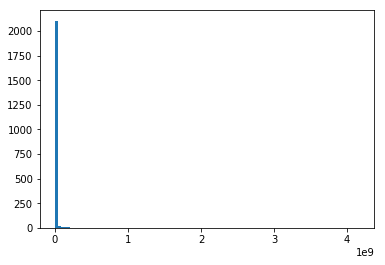

In [133]:
# display population distribution
wiki_pop_ser = pd.Series(wiki_pops)
# get rid of inaccessible stuff
wiki_pop_valid = wiki_pop_ser[wiki_pop_ser > 0]
print('%d/%d valid pops'%(len(wiki_pop_valid), len(wiki_pop_ser)))
plt.hist(wiki_pop_valid, bins=100)
plt.show()

Log-transform might show distribution better.

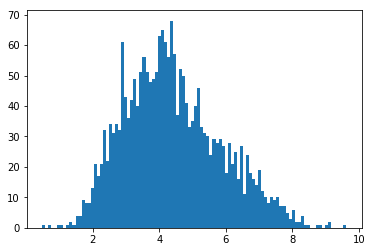

In [134]:
plt.hist(pd.np.log10(wiki_pop_valid), bins=100)
plt.show()

There we go! Log-population follows a normal distribution.

In [135]:
wiki_pop_valid.sort_values(inplace=True, ascending=True)
print(wiki_pop_valid.head(20))
print(wiki_pop_valid.tail(20))

Q6522749      3
Q3475688      5
Q16464952    10
Q4892743     11
Q4512420     17
Q2193813     23
Q576936      23
Q67363       29
Q2316274     31
Q20664252    32
Q126318      34
Q164133      36
Q1959011     39
Q28121       40
Q1934037     41
Q934783      43
Q1510107     48
Q2788855     49
Q1376083     49
Q7137175     51
dtype: int64
Q928       100981437
Q4478      101391000
Q1165      103804637
Q40556     115000000
Q17        127110047
Q96        130526945
Q159       146804372
Q902       156594962
Q843       182142594
Q1033      182202000
Q1498      199581477
Q155       200361925
Q252       249865631
Q30        323952889
Q49        565265000
Q46        741447158
Q15       1100000000
Q668      1339180127
Q148      1409517397
Q48       4164252000
dtype: int64


In [136]:
# join to data so we can tell wtf is going on
geocorpora_query_results_with_wiki.loc[:, 'wikidata_ID'] = geocorpora_query_results_with_wiki.loc[:, 'annotations'].apply(lambda x: x['wikidata'])

In [138]:
wiki_pop_valid_df = pd.DataFrame(wiki_pop_valid)
wiki_pop_valid_df.columns = ['wikidata_pop']
wiki_pop_valid_df.loc[:, 'wikidata_ID'] = wiki_pop_valid_df.index.tolist()
print(wiki_pop_valid_df.head())
geocorpora_query_results_with_pop = pd.merge(geocorpora_query_results_with_wiki, wiki_pop_valid_df, on='wikidata_ID')
print(geocorpora_query_results_with_pop.head())

           wikidata_pop wikidata_ID
Q6522749              3    Q6522749
Q3475688              5    Q3475688
Q16464952            10   Q16464952
Q4892743             11    Q4892743
Q4512420             17    Q4512420
                                         annotations  \
0  {u'MGRS': u'32NKL6270635529', u'sun': {u'rise'...   
1  {u'MGRS': u'32NKL6270635529', u'sun': {u'rise'...   
2  {u'MGRS': u'32PLR9026461351', u'sun': {u'rise'...   
3  {u'MGRS': u'16SEB1587780000', u'sun': {u'rise'...   
4  {u'MGRS': u'17TQH1233974829', u'sun': {u'rise'...   

                                              bounds  \
0  {u'northeast': {u'lat': 5.7300358, u'lng': 7.5...   
1  {u'northeast': {u'lat': 5.7300358, u'lng': 7.5...   
2  {u'northeast': {u'lat': 13.885645, u'lng': 14....   
3  {u'northeast': {u'lat': 35.0081121, u'lng': -8...   
4  {u'northeast': {u'lat': 43.116448, u'lng': -78...   

                                          components  confidence  \
0  {u'country': u'Nigeria', u'ISO_3166-1_a

OK great! Now we can write to file.

In [141]:
pop_out_file = '../../data/geo_files/population_data/wikidata_population.tsv'
wiki_pop_valid_df.to_csv(pop_out_file, sep='\t', index=False)

## Get number of alternative names
Another common feature for toponym resolution is the number of alternative names that a location has.

TODO: We can proxy this feature from DBPedia which has a "SameAs" feature with alternative names and non-English language pages.

In [ ]:
from SPARQLWrapper import SPARQLWrapper


We can also get this info from Wikidata based on number of non-English pages.

In [142]:
def query_wikidata_other_pages(wikidata_ID):
    """
    Query Wikidata for population if available.
    """
    WIKI_QUERY = """SELECT (count(?lang) as ?numLang) WHERE { 
        wd:%s rdfs:label ?label . 
        filter(!langmatches(lang(?label), 'en')) bind(lang(?label) as ?lang) 
        }
    """%(wikidata_ID)
    WIKI_QUERY_FULL = WIKI_URL%(WIKI_QUERY)
    headers = {"Accept" : "application/json"}
    req = requests.get(WIKI_QUERY_FULL, headers=headers)
    req_json = req.json()
    lang_count = int(req_json['results']['bindings'][0]['numLang']['value'])
    return(lang_count)

In [143]:
test_id = 'Q503923'
test_json = query_wikidata_other_pages(test_id)
print(test_json)

{u'head': {u'vars': [u'numLang']}, u'results': {u'bindings': [{u'numLang': {u'datatype': u'http://www.w3.org/2001/XMLSchema#integer', u'type': u'literal', u'value': u'52'}}]}}
